# 公募基金组合

## 本段代码利用quantOS系统进行公募股票和债券基金收益率分析及组合构建，比较了等权重和波动率倒数加权法两种组合构建方法

## 系统设置

In [1]:
# encoding: utf-8
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import matplotlib.mlab as mlab
import scipy.stats as stats
from matplotlib.ticker import Formatter

sns.set_style('darkgrid')
sns.set_context('poster')
%matplotlib inline

In [2]:
from jaqs.data import RemoteDataService, DataApi
import jaqs.util as jutil
from __future__ import print_function, unicode_literals, division, absolute_import

from jaqs.data import RemoteDataService, DataView

In [3]:
dataview_dir_path = '.'
backtest_result_dir_path = '.'

import os
phone = os.environ.get('QUANTOS_USER')
token = os.environ.get('QUANTOS_TOKEN')

data_config = {
  "remote.data.address": "tcp://data.quantos.org:8910",
  "remote.data.username": phone,
  "timeout": 3600,
  "remote.data.password": token
}

api_uat = DataApi(addr='tcp://data.quantos.org:8910')
api_uat.login(phone, token)

ds = RemoteDataService()
ds.init_from_config(data_config)


Begin: DataApi login 17321165656@tcp://data.quantos.org:8910
    login success 



'0,'

## 设置参数

In [37]:
START_DATE, END_DATE = 20160101, 20180511

## 从数据库中取出符合条件的基金

In [77]:
def get_fundlist(api, invest_type, invest_style,launch_date):
    df, msg = api.query(
            view = 'lb.mfInfo',
            fields = 'invest_type,invest_style,status',
            filter = "",
            data_format = 'pandas'
    )
    df = df[(df['invest_type'] == invest_type)
           & (df['status'] == 101001000)
           & (df['invest_style'] == invest_style)
           & (df['setup_date'] < launch_date)]
    return df

## 取出基金历史净值和指数的历史价格信息，注意需要用复权因子校正后的净值

In [6]:
def get_fundnav(api, symbol, start_date, end_date):
    df, msg = api.query(
            view = 'lb.mfNav',
            fields = 'price_date,nav_adjusted',
            filter = 'start_pdate=' + str(start_date) + '&end_pdate=' + str(end_date) + '&symbol=' + symbol,
            data_format = 'pandas'
    )
    
    if df is None:
        print(df, msg)
    df.index = df['price_date'].astype(np.integer)
    df.sort_index(inplace = True)
    return df

## 计算每只基金的表现，包括return，volatility，sharpe ratio，beta，最大回撤等

In [113]:
def cal_return(api, symbol, start, end):

    df_nav = get_fundnav(api, symbol, start, end)
    if len(df_nav) == 0:
        return None, None, None
    strategy_value = pd.DataFrame(df_nav['nav_accumulated']).fillna(method = 'ffill')
    strategy_value.columns = ['strat']
    df_returns = strategy_value.pct_change(periods = 1).fillna(0.0)
    df_returns = df_returns.join((df_returns.loc[:, ['strat']] + 1.0).cumprod(), rsuffix = '_cum')

    start = pd.to_datetime(start, format = '%Y%m%d')
    end   = pd.to_datetime(end, format = '%Y%m%d')
    years = (end - start).days / 365.0

    strat_cum = df_returns['strat_cum'].values

#     max_dd_end = np.argmax(np.maximum.accumulate(strat_cum) - strat_cum)   # end of the period
#     max_dd_start   = np.argmax(strat_cum[:max_dd_end])
#     max_dd = (strat_cum[max_dd_start] - strat_cum[max_dd_end])/strat_cum[max_dd_end]

    # 计算收益率相关指标
    performance_metrics = dict()

    performance_metrics['Annual Return (%)'] =\
        100 * (np.power(df_returns.loc[:, 'strat_cum'].values[-1], 1./years) - 1)
    performance_metrics['Annual volatility (%)'] =\
        100 * (df_returns.loc[:, 'strat'].std() * np.sqrt(242))
    performance_metrics['Sharpe Ratio'] = (performance_metrics['Annual Return (%)']/performance_metrics['Annual volatility (%)'])

    # 计算风险相关指标
    risk_metrics = dict()
#     risk_metrics['Maximum Drawdown (%)'] = max_dd * 100
#     risk_metrics['Maximum Drawdown Start'] = df_returns.index[max_dd_end]
#     risk_metrics['Maximum Drawdown End'] = df_returns.index[max_dd_start]
    
    output_returns = df_returns.copy()
    output_returns['symbol'] = symbol
    output_returns = output_returns.reset_index()
    output_returns.columns = ['trade_date', 'strat','strat_cum','symbol']
    
    return performance_metrics, risk_metrics, output_returns

## 将上述函数按流程组织在一起，计算出所有符合条件基金的表现

In [154]:
# 剔除指数型基金以及2018年1月1日后发行的股票和债券基金，债券基金选择发行规模最大的1000支作为研究对象
df = get_fundlist(api_uat, '股票型', '股票型', str(20180101))
df_bond = get_fundlist(api_uat, '债券型', '债券型', str(20180101))
df_bond = df_bond.sort_values('issue_totals', ascending = False).head(1000)

In [155]:
symbols = df['symbol'].values.tolist()
symbols_bond = df_bond['symbol'].values.tolist()

In [156]:
indicators = list()
indicators_bond = list()

In [157]:
daily_returns = pd.DataFrame()
daily_returns_bond = pd.DataFrame()

In [158]:
for symbol in symbols:
    performance_metrics, risk_metrics, output_returns = cal_return(api_uat, symbol, START_DATE, END_DATE)
    
    if performance_metrics is None:
        continue
    daily_returns = pd.concat([daily_returns, output_returns], axis = 0)
    indicators.append((symbol,
                      performance_metrics['Annual Return (%)'],
                      performance_metrics['Annual volatility (%)'],
                      performance_metrics['Sharpe Ratio'],
                      output_returns['strat_cum'].iat[-1]))

In [159]:
for symbol in symbols_bond:
    performance_metrics, risk_metrics, output_returns = cal_return(api_uat, symbol, START_DATE, END_DATE)
    
    if performance_metrics is None:
        continue
    daily_returns_bond = pd.concat([daily_returns_bond, output_returns], axis = 0)
    indicators_bond.append((symbol,
                      performance_metrics['Annual Return (%)'],
                      performance_metrics['Annual volatility (%)'],
                      performance_metrics['Sharpe Ratio'],
                      output_returns['strat_cum'].iat[-1]))

In [160]:
labels = ['symbol', 'AnnualReturn', 'AnnualVolatility', 'SharpeRatio', 'StratCumReturn']

## 股票基金收益率描述统计

In [161]:
df_returns = pd.DataFrame.from_records(indicators, columns = labels)
df_returns.describe()

,AnnualReturn,AnnualVolatility,SharpeRatio,StratCumReturn
count,307.000000,307.000000,307.000000,307.000000
mean,4.364186,18.482186,0.303119,1.118137
std,8.636670,4.854557,0.639726,0.219610
min,-21.810494,0.386981,-0.902726,0.559690
25%,-1.415731,15.445819,-0.078384,0.966925
50%,3.587610,19.102425,0.206999,1.086700
75%,10.078499,21.538705,0.616507,1.254229
max,30.874093,39.064090,7.204041,1.886456


In [162]:
df_returns = pd.merge(left = df_returns, right = df[['symbol', 'issue_totals']], how = 'left', on = 'symbol')

## 股票基金年化收益率分布

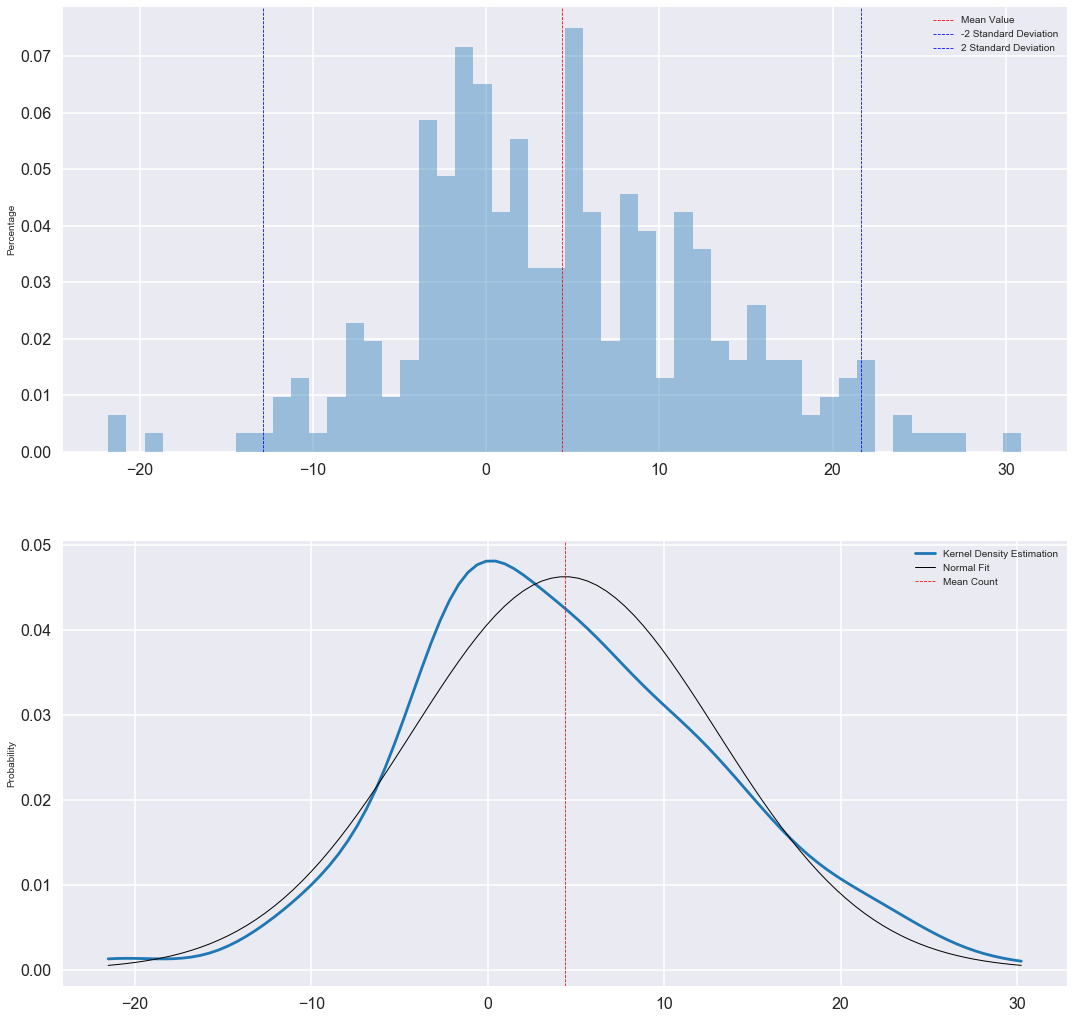

In [163]:
# 画日对数收益率分布直方图
fig = plt.figure(figsize=(18, 18))
v = df_returns['AnnualReturn'].dropna().values
avgRet = np.mean(v)
stdRet = np.std(v)
x = np.linspace(avgRet - 3*stdRet, avgRet + 3*stdRet, 100)
y = mlab.normpdf(x, avgRet, stdRet)
kde = stats.gaussian_kde(v)

# plot the histogram
plt.subplot(211)
plt.hist(v, 50, weights = np.ones(len(v))/len(v), alpha = 0.4)
plt.axvline(x = avgRet, color = 'red', linestyle = '--', linewidth = 0.8, label = 'Mean Value')
plt.axvline(x = avgRet - 2 * stdRet, color = 'blue', linestyle = '--', linewidth = 0.8, label = '-2 Standard Deviation')
plt.axvline(x = avgRet + 2 * stdRet, color = 'blue', linestyle = '--', linewidth = 0.8, label = '2 Standard Deviation')
plt.ylabel('Percentage', fontsize = 10)
plt.legend(fontsize = 10)

# plot the kde and normal fit
plt.subplot(212)
plt.plot(x, kde(x), label = 'Kernel Density Estimation')
plt.plot(x, y, color = 'black', linewidth=1, label = 'Normal Fit')
plt.ylabel('Probability', fontsize = 10)
plt.axvline(x = avgRet, color = 'red', linestyle = '--', linewidth = 0.8, label = 'Mean Count')
plt.legend(fontsize = 10)

## 债券基金收益率描述统计

In [164]:
df_returns_bond = pd.DataFrame.from_records(indicators_bond, columns = labels)
df_returns_bond.describe()

,AnnualReturn,AnnualVolatility,SharpeRatio,StratCumReturn
count,998.000000,998.000000,998.000000,998.000000
mean,1.416466,2.560495,1.284039,1.034567
std,2.282857,2.557381,1.541210,0.052420
min,-20.272923,0.194170,-1.540819,0.586000
25%,0.880961,1.092701,0.361577,1.020906
50%,1.718000,1.771565,0.960840,1.041000
75%,2.469773,3.171727,1.872507,1.059240
max,13.288286,32.461291,20.173094,1.342200


In [165]:
df_returns_bond = pd.merge(left = df_returns_bond, right = df_bond[['symbol', 'issue_totals']], how = 'left', on = 'symbol')

## 债券基金年化收益率分布

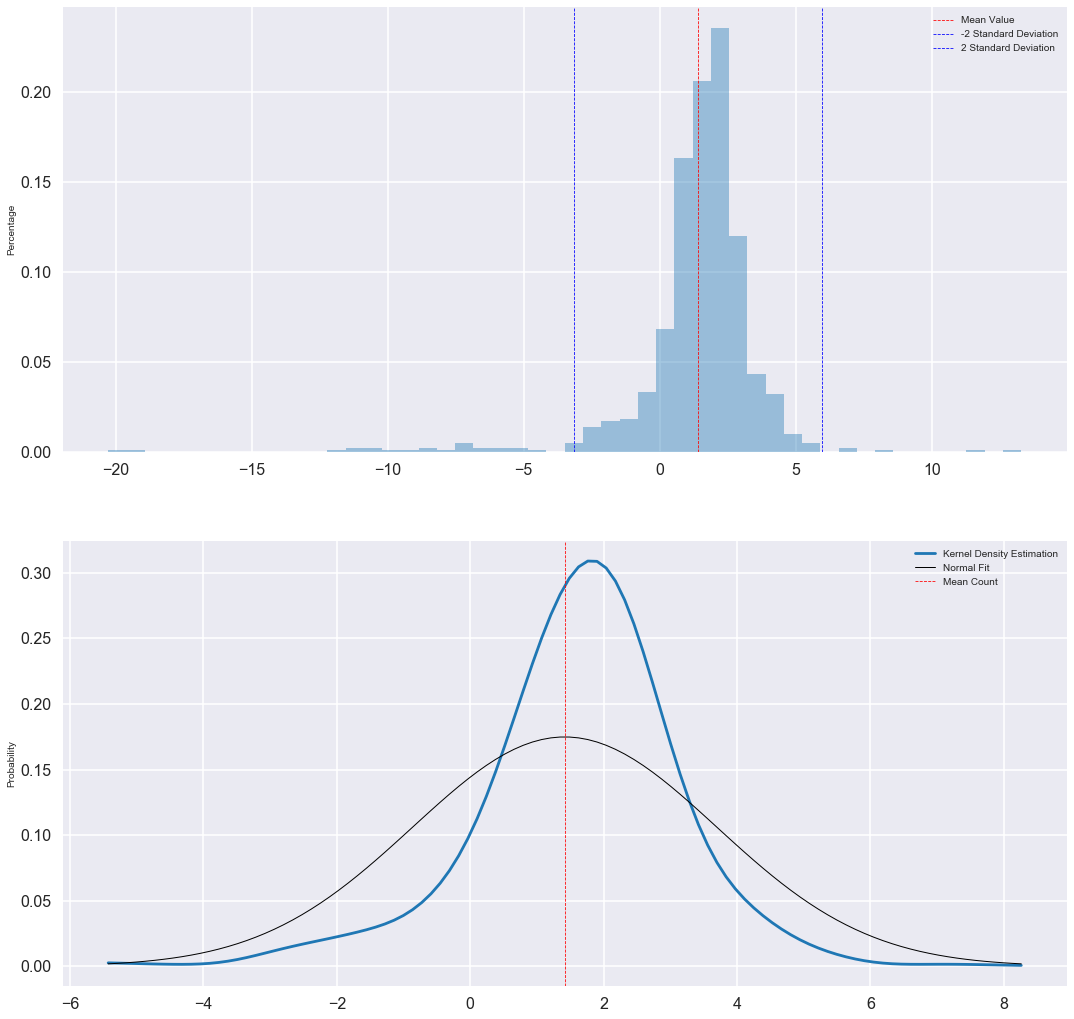

In [166]:
# 画日对数收益率分布直方图
fig = plt.figure(figsize=(18, 18))
v = df_returns_bond['AnnualReturn'].dropna().values
avgRet = np.mean(v)
stdRet = np.std(v)
x = np.linspace(avgRet - 3*stdRet, avgRet + 3*stdRet, 100)
y = mlab.normpdf(x, avgRet, stdRet)
kde = stats.gaussian_kde(v)

# plot the histogram
plt.subplot(211)
plt.hist(v, 50, weights = np.ones(len(v))/len(v), alpha = 0.4)
plt.axvline(x = avgRet, color = 'red', linestyle = '--', linewidth = 0.8, label = 'Mean Value')
plt.axvline(x = avgRet - 2 * stdRet, color = 'blue', linestyle = '--', linewidth = 0.8, label = '-2 Standard Deviation')
plt.axvline(x = avgRet + 2 * stdRet, color = 'blue', linestyle = '--', linewidth = 0.8, label = '2 Standard Deviation')
plt.ylabel('Percentage', fontsize = 10)
plt.legend(fontsize = 10)

# plot the kde and normal fit
plt.subplot(212)
plt.plot(x, kde(x), label = 'Kernel Density Estimation')
plt.plot(x, y, color = 'black', linewidth=1, label = 'Normal Fit')
plt.ylabel('Probability', fontsize = 10)
plt.axvline(x = avgRet, color = 'red', linestyle = '--', linewidth = 0.8, label = 'Mean Count')
plt.legend(fontsize = 10)

In [167]:
df_daily_returns_bond = daily_returns_bond.pivot_table(index = 'trade_date', columns = 'symbol', values = 'strat')
df_daily_returns_bond = df_daily_returns_bond.fillna(0.0)

In [168]:
df_daily_returns = daily_returns.pivot_table(index = 'trade_date', columns = 'symbol', values = 'strat')
df_daily_returns = df_daily_returns.fillna(0.0)

## 比较同一股票基金在不同年份的表现，检验是否有持续性

In [43]:
df_daily_returns_2016 = df_daily_returns.loc[:20170101]
df_daily_returns_2017 = df_daily_returns.loc[20170101:20180101]
df_daily_returns_2018 = df_daily_returns.loc[20180101:]

In [61]:
df_daily_returns_2016_cum = pd.DataFrame((df_daily_returns_2016 + 1).cumprod().iloc[-1, :].rank(ascending = False))
df_daily_returns_2016_cum.columns = ['2016rank']
df_daily_returns_2017_cum = pd.DataFrame((df_daily_returns_2017 + 1).cumprod().iloc[-1, :].rank(ascending = False))
df_daily_returns_2017_cum.columns = ['2017rank']
df_daily_returns_2018_cum = pd.DataFrame((df_daily_returns_2018 + 1).cumprod().iloc[-1, :].rank(ascending = False))
df_daily_returns_2018_cum.columns = ['2018rank']

In [63]:
df_rank = pd.concat([df_daily_returns_2016_cum, df_daily_returns_2017_cum, df_daily_returns_2018_cum], axis = 1)

In [65]:
df_rank.corr()

,2016rank,2017rank,2018rank
2016rank,1.000000,0.082479,0.144213
2017rank,0.082479,1.000000,0.011841
2018rank,0.144213,0.011841,1.000000


## 比较同一债券基金在不同年份的表现，检验是否有持续性

In [170]:
df_daily_returns_bond_2016 = df_daily_returns_bond.loc[:20170101]
df_daily_returns_bond_2017 = df_daily_returns_bond.loc[20170101:20180101]
df_daily_returns_bond_2018 = df_daily_returns_bond.loc[20180101:]

In [171]:
df_daily_returns_bond_2016_cum = pd.DataFrame((df_daily_returns_bond_2016 + 1).cumprod().iloc[-1, :].rank(ascending = False))
df_daily_returns_bond_2016_cum.columns = ['2016rank']
df_daily_returns_bond_2017_cum = pd.DataFrame((df_daily_returns_bond_2017 + 1).cumprod().iloc[-1, :].rank(ascending = False))
df_daily_returns_bond_2017_cum.columns = ['2017rank']
df_daily_returns_bond_2018_cum = pd.DataFrame((df_daily_returns_bond_2018 + 1).cumprod().iloc[-1, :].rank(ascending = False))
df_daily_returns_bond_2018_cum.columns = ['2018rank']

In [172]:
df_rank_bond = pd.concat([df_daily_returns_bond_2016_cum, df_daily_returns_bond_2017_cum, df_daily_returns_bond_2018_cum], axis = 1)

In [174]:
df_rank_bond.corr()

,2016rank,2017rank,2018rank
2016rank,1.000000,0.148519,-0.023175
2017rank,0.148519,1.000000,-0.047603
2018rank,-0.023175,-0.047603,1.000000


## 挑选出在2016年表现最好的三支股票基金和债券基金构建组合

In [185]:
stock_fund = df_daily_returns_2016_cum.sort_values('2016rank').index[:3].values.tolist()
bond_fund = df_daily_returns_bond_2016_cum.sort_values('2016rank').index[:3].values.tolist()

In [193]:
daily_ret_stock = df_daily_returns[stock_fund]
daily_ret_bond = df_daily_returns_bond[bond_fund]
daily_ret_all = pd.concat([daily_ret_stock, daily_ret_bond], axis = 1)

## 1. 等权重组合基金

In [195]:
df_ew = pd.DataFrame(daily_ret_all.mean(axis = 1))
df_ew.columns = ['daily_ew_ret']

In [196]:
print('Annual Return is: %.4f' % (df_ew.mean() * 242))
print('Annual Volatility is: %.4f' % (df_ew.std() * np.sqrt(242)))
print('Sharpe Ratio is: %.4f' % (df_ew.mean()/df_ew.std() * np.sqrt(242)))

Annual Return is: 0.1026
Annual Volatility is: 0.0664
Sharpe Ratio is: 1.5452


## 2. 根据波动率倒数组合基金

In [197]:
# 计算各支基金过去30个交易日波动率
df_volatility = pd.rolling_std(daily_ret_all, 30)
df_volatility = df_volatility.dropna()

C:\Users\lli\AppData\Local\QuantosFinanceTerminal\python\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=30,center=False).std()
  


In [198]:
# 根据波动率确定各支基金在组合中的权重
df_inverse_volatility = 1.0/df_volatility
df_inverse_volatility = df_inverse_volatility.replace(np.inf, 0.0)
df_weight = df_inverse_volatility.divide(df_inverse_volatility.sum(axis = 1), axis = 0)

In [199]:
# 根据权重组合各支基金
df_rp = pd.DataFrame(df_daily_returns.loc[df_weight.index].mul(df_weight).sum(axis = 1))
df_rp.columns = ['daily_rp_ret']

In [200]:
print('Annual Return is: %.4f' % (df_rp.mean() * 242))
print('Annual Volatility is: %.4f' % (df_rp.std() * np.sqrt(242)))
print('Sharpe Ratio is: %.4f' % (df_rp.mean()/df_rp.std() * np.sqrt(242)))

Annual Return is: 0.0242
Annual Volatility is: 0.0194
Sharpe Ratio is: 1.2487


In [201]:
class MyFormatter(Formatter):
    def __init__(self, dates, fmt='%Y%m'):
        self.dates = dates
        self.fmt = fmt

    def __call__(self, x, pos=0):
        """Return the label for time x at position pos"""
        ind = int(np.round(x))
        if ind >= len(self.dates) or ind < 0:
            return ''

        # return self.dates[ind].strftime(self.fmt)
        return pd.to_datetime(self.dates[ind], format="%Y%m%d").strftime(self.fmt)

In [202]:
df_ret_compare = pd.concat([df_ew, df_rp], axis = 1)
df_ret_compare = df_ret_compare.dropna()

In [203]:
df_cum_ret_compare = (df_ret_compare + 1).cumprod()

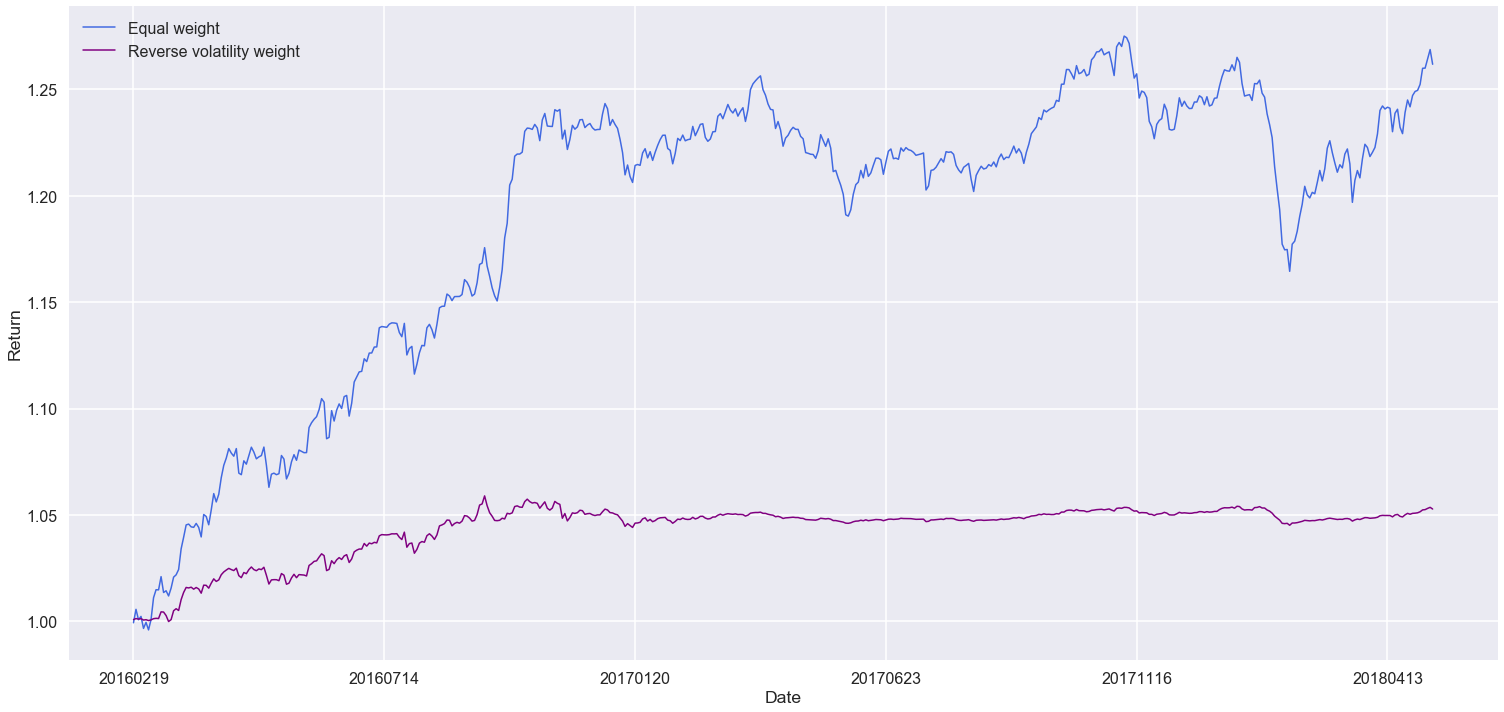

In [204]:
fig, ax1 = plt.subplots(1, 1, figsize=(21, 10))

idx0 = df_cum_ret_compare.index
idx = range(len(idx0))

# ax1.plot(idx, df_cum_ret_compare.daily_issue_ret, lw=1.5, color='indianred', label='Issue value weight')
ax1.plot(idx, df_cum_ret_compare.daily_ew_ret, lw=1.5, color='royalblue', label='Equal weight')
ax1.plot(idx, df_cum_ret_compare.daily_rp_ret, lw=1.5, color='purple', label='Reverse volatility weight')

# ax1.axhline(0.0, color='k', lw=0.5, ls='--')

ax1.legend(loc='upper left')
ax1.set_xlabel("Date")
ax1.set_ylabel("Return")
ax1.xaxis.set_major_formatter(MyFormatter(idx0, '%Y%m%d'))

plt.tight_layout()
# fig.savefig('lgt_brinson_cum.png')
# plt.close()

## 注解：
## 1. 债券基金在2017年表现较差，而股票基金表现更好
## 2. 第二种根据波动率倒数的加权方式更倾向于债券基金，所以在样本内表现不如等权重组合